In [0]:
import os
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np

import IPython

from PIL import Image

import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow import keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.preprocessing import image as kimage
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications import vgg19

tf.enable_eager_execution()
assert tf.executing_eagerly()

In [2]:
from google.colab import drive
drive.mount("/content/drive")

gdrive_path = "mixed_nst"

os.chdir("/content/drive/My Drive/" + gdrive_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def load_img(path):
    img = kimage.load_img(path)
    
    scale = 800 / max(img.size)
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)), Image.ANTIALIAS)
    
    img = kimage.img_to_array(img).astype(np.uint8)
    
    return img


def preprocess_img(img):
    return vgg19.preprocess_input(np.expand_dims(img, axis=0))


def postprocess_img(img):
    img = img.copy()
    
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68

    img = img[:, :, ::-1]
    
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    return img

In [4]:
content_layers = ['block5_conv2'] 

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1', 
    'block4_conv1', 
    'block5_conv1'
]

base_model = vgg19.VGG19(include_top=False, weights="imagenet")

model_outputs = [
    base_model.get_layer(name).output
    for name in chain(content_layers, style_layers)
]

model = Model(inputs=base_model.input, outputs=model_outputs)

for layer in model.layers:
    layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 1s 0us/step


In [0]:
def mse_loss(x, y):
    return tf.reduce_mean(tf.square(x - y))


def gram_matrix(x):
    n_chans = x.shape[-1]
    a = tf.reshape(x, [-1, n_chans])
    n = tf.shape(a)[0]
    y = tf.matmul(a, a, transpose_a=True)
    return y / tf.cast(n, tf.float32)


def compute_content_loss(content_features, target_content_features):
    y = 0
    
    weight_per_content_layer = 1 / len(content_layers)
    
    for target_content_ft, content_ft in zip(target_content_features, content_features):
        y += weight_per_content_layer * mse_loss(target_content_ft, content_ft)
       
    return y


def compute_style_loss(style_features, target_style_grams):
    y = 0
    
    weight_per_style_layer = 1 / len(style_layers)
    
    for target_style_gram, style_ft in zip(target_style_grams, style_features):
        y += weight_per_style_layer * mse_loss(target_style_gram, gram_matrix(style_ft))
    
    return y


def compute_loss(img, target_content_features, styles_grams, content_weight, style_weights):
    model_output = model(img)
    
    content_features = model_output[:len(content_layers)]
    style_features = model_output[len(content_layers):]
    
    content_loss = compute_content_loss(content_features, target_content_features)
    
    style_loss = 0
    
    for w, style_grams in zip(style_weights, styles_grams):
        style_loss += w * compute_style_loss(style_features, style_grams)
    
    loss = content_weight * content_loss + style_loss
    
    return loss


def run_style_transfer(content, styles, n_iters=1000, content_weight=1e3, style_weights=1e-2):
    if isinstance(style_weights, float):
        style_weights = [style_weights] * len(styles)
    
    content = preprocess_img(content)
    content_features = [layer[0] for layer in model(content)[:len(content_layers)]]
    
    styles = [*map(preprocess_img, styles)]
    styles_grams = [
        [gram_matrix(layer[0]) for layer in model(style)[len(content_layers):]]
        for style in styles
    ]
    
    img = content.copy().astype(np.float32)
    img = tfe.Variable(img, dtype=tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
#     opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    
    best_loss = float("inf")
    best_img = None
    
    display_interval = 30
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    for i in range(n_iters):
        with tf.GradientTape() as tape:
            loss = compute_loss(img, content_features, styles_grams, content_weight, style_weights)
        
        grads = tape.gradient(loss, img)
        opt.apply_gradients([(grads, img)])
        
        clipped_img = tf.clip_by_value(img, min_vals, max_vals)
        
        img.assign(clipped_img)
        
        if loss < best_loss:
            best_loss = loss
            best_img = img
        
        if i % display_interval == 0:
            plt_img = postprocess_img(np.squeeze(img.numpy(), axis=0))
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plt_img))

            print(i, loss.numpy())
    
    best_img = postprocess_img(np.squeeze(best_img.numpy(), axis=0))
    
    return best_img, best_loss.numpy()

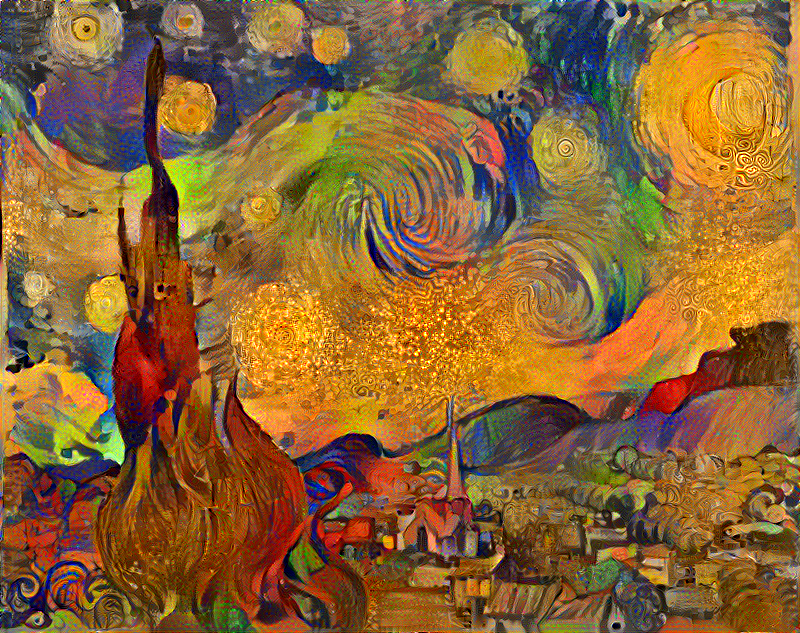

4980 115600250.0


In [6]:
img, loss = run_style_transfer(
    load_img("Starry Night.jpg"),
    [load_img("Fauvism.jpg"), load_img("Adele.jpg")],
    n_iters=5000
)